In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

spark = SparkSession.builder \
    .appName("HousePricePrediction_GBT") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.extraJavaOptions", "-Xss4m") \
    .config("spark.executor.extraJavaOptions", "-Xss4m") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "100") \
    .getOrCreate()

In [2]:
from pathlib import Path

DATA_DIR = Path.cwd().parent / 'files'
train_path = str(DATA_DIR / "train.csv")
test_path  = str(DATA_DIR/"test.csv")

train_df = (spark.read
            .option("header", "true")
            .option("inferSchema", "true")   # 关键：自动推断数值类型
            .option("nullValue", "NA")       # 可选：明确 NA 为 null
            .csv(train_path))

test_df = (spark.read
           .option("header", "true")
           .option("inferSchema", "true")
           .option("nullValue", "NA")
           .csv(test_path))

print("=== Train Schema ===")
train_df.printSchema()
print(f"Train rows: {train_df.count()}, cols: {len(train_df.columns)}")

print("\n=== Test Schema ===")
test_df.printSchema()

=== Train Schema ===
root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string 

In [3]:
# === 区分列类型（基于实际 schema）===

from pyspark.sql.types import IntegerType, DoubleType, StringType

num_cols = [field.name for field in train_df.schema.fields
            if isinstance(field.dataType, (IntegerType, DoubleType))
            and field.name != "SalePrice"]

cat_cols = [field.name for field in train_df.schema.fields
            if isinstance(field.dataType, StringType)]

print(f"数值列 ({len(num_cols)}): {num_cols[:10]}...")
print(f"类别列 ({len(cat_cols)}): {cat_cols[:10]}...")

数值列 (37): ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1']...
类别列 (43): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1']...


In [4]:
from pyspark.sql import functions as F
# === 数值列：中位数填补 ===
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=num_cols, outputCols=num_cols, strategy="median")

# 分别 fit，避免 train/test 统计泄露
train_df = imputer.fit(train_df).transform(train_df)
test_df  = imputer.fit(test_df).transform(test_df)

# === 类别列：缺失值填 "Missing" ===
for c in cat_cols:
    train_df = train_df.fillna({c: "Missing"})
    test_df  = test_df.fillna({c: "Missing"})

# 验证无缺失
print("数值列缺失统计:")
train_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in num_cols]).show()

数值列缺失统计:
+---+----------+-----------+-------+-----------+-----------+---------+------------+----------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+-----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+
| Id|MSSubClass|LotFrontage|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|MasVnrArea|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|BsmtFullBath|BsmtHalfBath|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|GarageYrBlt|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|
+---+----------+-----------+-------+-----------+-----------+---------+------------+----------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+---

In [5]:
# === 类别编码：StringIndexer + OneHotEncoder ===
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="keep")
    for c in cat_cols
]

encoders = [
    OneHotEncoder(inputCol=c + "_idx", outputCol=c + "_vec", handleInvalid="keep")
    for c in cat_cols
]

from pyspark.ml.feature import VectorAssembler

# 最终特征向量
feature_cols = [c + "_vec" for c in cat_cols] + num_cols   # num_cols 保持原始值
assembler_final = VectorAssembler(inputCols=feature_cols,
                                  outputCol="features",
                                  handleInvalid="keep")

# 目标：对 SalePrice 取 log
import pyspark.sql.functions as F
train_df = train_df.withColumn("logSalePrice", F.log1p(F.col("SalePrice")))
target_col = "logSalePrice"

In [ ]:
# === 1. 导入 GBTRegressor ===
from pyspark.ml.regression import GBTRegressor

# === 2. 替换原 RF 定义 ===
gbt = GBTRegressor(
    featuresCol="features",
    labelCol=target_col,
    maxIter=500,        # 提升轮数（树棵数）
    maxDepth=6,         # 单棵树最大深度
    stepSize=0.05,       # 学习率
    subsamplingRate=0.8,
    seed=42
)

# === 3. 重新组装 Pipeline（其余 stage 不变） ===
pipeline_gbt = Pipeline(stages=indexers + encoders + [assembler_final, gbt])

In [7]:
train_set, val_set = train_df.randomSplit([0.8, 0.2], seed=42)
from pyspark.ml.evaluation import RegressionEvaluator
# === 4. 训练与评估（把原来的 pipeline_rf 换成 pipeline_gbt） ===
model_gbt = pipeline_gbt.fit(train_set)
pred_gbt = model_gbt.transform(val_set)

evaluator = RegressionEvaluator(labelCol=target_col, metricName="rmse")
rmse_gbt = evaluator.evaluate(pred_gbt)
r2_gbt = RegressionEvaluator(labelCol=target_col, metricName="r2").evaluate(pred_gbt)
print(f"GBT RMSE (log): {rmse_gbt:.4f}, R²: {r2_gbt:.4f}")

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "d:\anaconda3\envs\pyspark_env\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\pyspark_env\Lib\socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] 远程主机强迫关闭了一个现有的连接。

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\anaconda3\envs\pyspark_env\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\pyspark_env\Lib\site-packages\py4j\clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: An error occurred while calling o699.fit

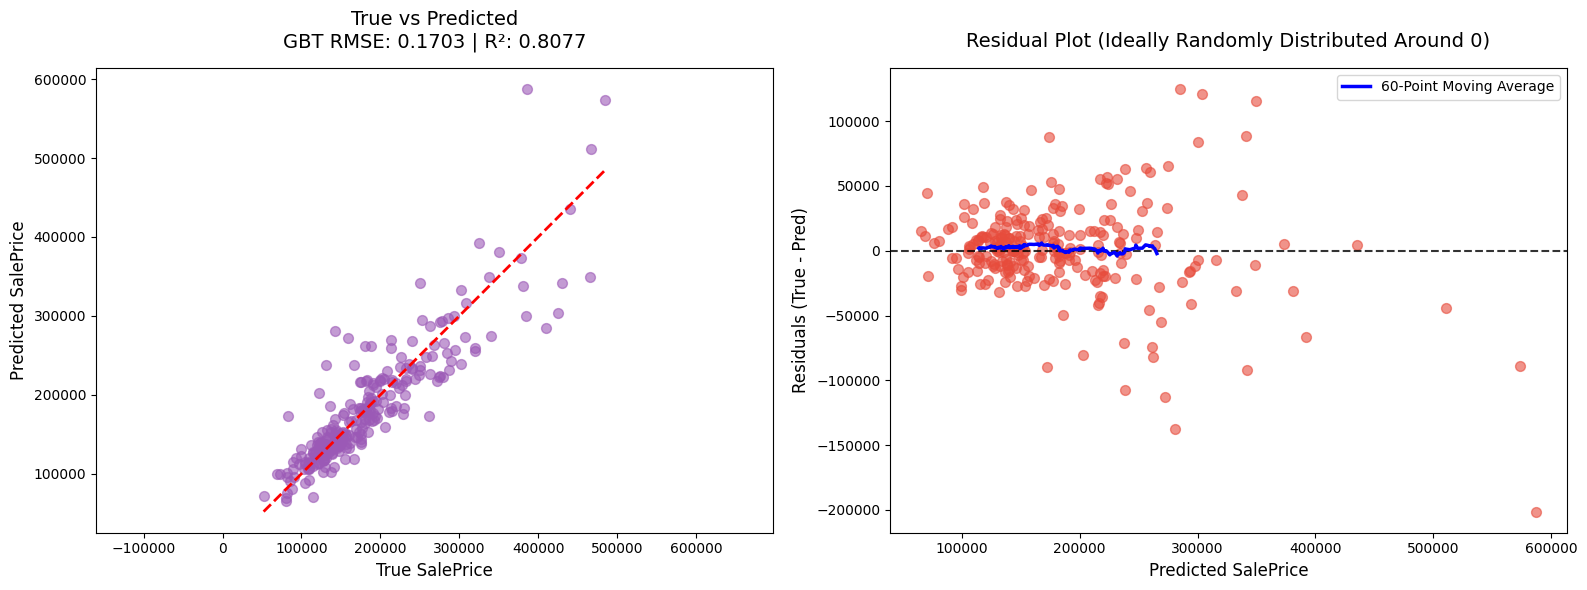

In [ ]:
# ============== 5 真实值 vs 预测值 + 残差图（GBT 模型）==============
pred_pd = pred_gbt.select("logSalePrice", "prediction").toPandas()
pred_pd["TruePrice"] = np.expm1(pred_pd["logSalePrice"])
pred_pd["PredPrice"] = np.expm1(pred_pd["prediction"])
residuals = pred_pd["TruePrice"] - pred_pd["PredPrice"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 左图：真实 vs 预测
ax1.scatter(pred_pd["TruePrice"], pred_pd["PredPrice"], alpha=0.6, c="#9b59b6", s=50)
ax1.plot([pred_pd["TruePrice"].min(), pred_pd["TruePrice"].max()],
         [pred_pd["TruePrice"].min(), pred_pd["TruePrice"].max()], 'r--', lw=2)
ax1.set_xlabel("True SalePrice", fontsize=12)
ax1.set_ylabel("Predicted SalePrice", fontsize=12)
ax1.set_title(f"True vs Predicted\nGBT RMSE: {rmse_gbt:.4f} | R²: {r2_gbt:.4f}", fontsize=14, pad=15)
ax1.axis("equal")

# 右图：残差图
ax2.scatter(pred_pd["PredPrice"], residuals, alpha=0.6, c="#e74c3c", s=50)
ax2.axhline(0, color="black", linestyle="--", alpha=0.8)
ax2.set_xlabel("Predicted SalePrice", fontsize=12)
ax2.set_ylabel("Residuals (True - Pred)", fontsize=12)
ax2.set_title("Residual Plot (Ideally Randomly Distributed Around 0)", fontsize=14, pad=15)

# 添加移动平均趋势线（不依赖 statsmodels）
sorted_idx = pred_pd["PredPrice"].argsort()
sorted_pred = pred_pd["PredPrice"].iloc[sorted_idx]
sorted_res = residuals.iloc[sorted_idx]
rolling = sorted_res.rolling(window=60, center=True).mean()
ax2.plot(sorted_pred, rolling, color="blue", lw=2.5, label="60-Point Moving Average")

ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ============== 6 GBT 特征重要性 Top 20（带真实特征名）==============
gbt_model = model_gbt.stages[-1]  # GBTRegressorModel
importances = gbt_model.featureImportances.toArray()

# 重建特征名（和之前线性回归一样严谨）
feature_names = []
transformer_stages = model_gbt.stages[:-1]

for stage in transformer_stages:
    if hasattr(stage, "getOutputCol") and stage.getOutputCol().endswith("_idx"):
        col_name = stage.getOutputCol()[:-4]
        labels = stage.labels + ["OOV"]
        feature_names.extend([f"{col_name}_{label}" for label in labels])
    elif hasattr(stage, "getOutputCol") and stage.getOutputCol() == "features":
        feature_names.extend(num_cols)

# 构造重要性 DataFrame
import pandas as pd
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 8))
top20 = imp_df.head(20)
sns.barplot(data=top20, x="importance", y="feature", palette="mako")
plt.title("GBT Feature Importance Top 20", fontsize=16, pad=20)
plt.xlabel("Importance Score")
for i, v in enumerate(top20["importance"]):
    plt.text(v + 0.001, i, f"{v:.4f}", va="center", fontweight="bold")
plt.tight_layout()
plt.show()

# 打印 Top 10
print("Top 10 Most Important GBT Features:")
display(imp_df.head(10))

NameError: name 'model_gbt' is not defined

In [ ]:
from datetime import datetime
from pathlib import Path
import pyspark.sql.functions as F

# === 预测并转为 Pandas ===
submission_df = (model_gbt.transform(test_df)
                 .withColumn("SalePrice", F.exp(F.col("prediction")) - 1)
                 .select("Id", "SalePrice")
                 .toPandas())

# === 直接保存为 CSV（无需 Spark 写文件）===
RESULT_DIR = Path.cwd().parent / "results" / datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
RESULT_DIR.mkdir(parents=True, exist_ok=True)

submission_df.to_csv(RESULT_DIR / "submission.csv", index=False)

In [ ]:
spark.stop()